# Testing Machine Unlearning against Gaussian data poisoning

This is a sample implementation of gaussian data poisoning as described by the AI Security paper [Machine Unlearning Fails to Remove Data Poisoning Attacks
](https://arxiv.org/abs/2406.17216).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor
from copy import deepcopy
from typing import Tuple

# For reproducibility. Remove this for performance.
torch.manual_seed(0xdeadbeef)
np.random.seed(0xdeafcab)

Pick the most powerful device available.

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Let's define the function to be learned here. For now, we start with a linear function.

In [3]:
# Dimensions of linear regression
# TODO: change the dimensions
n = 1
p = 1
# Input shape
in_shape = (p,)
# Output shape
out_shape = (n,)

# The true parameters of the function to be learned by the model.
weights = torch.rand(n, p, device=device)
bias = torch.rand(n, device=device)
print('W:', weights, '\t', 'b:', bias)

def white_noise(n: int, std_noise: float):
    """
    Returns zero-centered noise with same shape as input features.
    """
    return torch.normal(0, std_noise, size=(n, *in_shape), device=device)

def f(x: Tensor) -> Tensor:
    """
    Returns an vector of length `n` from a vector of length `p`.
    
    This is the function to be learned.

    NOTE: this function can also be applied in batch by calling `f(X_batch)`
    where `X_batch` has a shape of the form `(N_batch, p)`.
    """
    #assert x.shape[1:] == in_shape
    s = 0.01
    # Add internal variation to make this regression problem relevant for ML
    # FIXME: this works because `f` is only called once.
    # `white_noise` is not deterministic, but `f` SHOULD be!
    eps = white_noise(len(x), s * x.std())
    return (x + eps) @ weights.T + bias

W: tensor([[0.7918]], device='cuda:0') 	 b: tensor([0.3894], device='cuda:0')


### Generate the dataset

We start by generating the clean, non-poisoned features.

In [4]:
from torch.utils.data import TensorDataset, DataLoader

N = 100_000
bs = 64

# TODO: see if data poisoning is affected by a specific initialization
X_base = torch.rand((N, *in_shape), device=device)
y_base = f(X_base)
print('Clean samples:', X_base.shape, y_base.shape)
ds = TensorDataset(X_base, y_base)

Clean samples: torch.Size([100000, 1]) torch.Size([100000, 1])


### Poison the training samples

The attacker poisons a fraction $\varepsilon$ of the features with noise $(\xi_z)_{z \in S_\mathrm{poison}}$ and stores the noise for future usage.

In [5]:
poison_budget = 0.02
N_poison = int(poison_budget * N)
N_clean = N - N_poison
epsilon = 0.2

std_noise = epsilon * X_base.std().item()
noise = white_noise(N_poison, std_noise)
# Another independent standard noise used as a baseline for unlearning evaluation
# (not used to corrupt the dataset)
dummy_noise = white_noise(N_poison, std_noise)

print('Noise data for poisoning:', noise.shape)

Noise data for poisoning: torch.Size([2000, 1])


In [6]:
def subset_to_tensor(s: torch.utils.data.Subset):
    # FIXME (perf): We cannot call `Tensor()` directly on a Subset,
    # so we have convert the subset to a list. This is inefficient.
    l = torch.concat(list(s))
    return l.reshape((len(s), *s[0].shape))

def poison_dataset(
    ds: TensorDataset, noise: Tensor,
) -> Tuple[TensorDataset, TensorDataset, TensorDataset, TensorDataset]:
    """
    Takes a dataset of `(x, y)` samples and adds the values in `noise`
    to a fraction of the `x` values.

    The order of the dataset is preserved.
    """
    N = len(ds)
    N_poison = len(noise)
    assert N_poison <= N

    to_poison_ds = TensorDataset(*ds[:N_poison])

    # This prevents any side effect on `ds`
    corrupted_ds = deepcopy(ds)
    corrupted_ds.tensors[0][:N_poison] += noise

    poison_ds = TensorDataset(*corrupted_ds[:N_poison])
    clean_ds = TensorDataset(*corrupted_ds[N_poison:])
    return to_poison_ds, poison_ds, clean_ds, corrupted_ds

to_poison_ds, poison_ds, clean_ds, corrupted_ds = poison_dataset(ds, noise)

X_to_poison = to_poison_ds.tensors[0] # To-be-poisoned samples, before poisoning
X_poison = poison_ds.tensors[0] # Poisoned samples
X_clean = clean_ds.tensors[0] # Untouched values
X_corrupted = corrupted_ds.tensors[0] # Entire dataset after poisoning

print(X_to_poison.shape, X_poison.shape, X_clean.shape, X_corrupted.shape)

torch.Size([2000, 1]) torch.Size([2000, 1]) torch.Size([98000, 1]) torch.Size([100000, 1])


Data poisoning creates a non-zero correlation between the poisoned data and the noise.

In [7]:
# Estimate correlation between the `kx` coordinate of the samples `X`
# and the `ky` coordinate of the samples `Y`.
def correlation(X: Tensor, Y: Tensor, kx=0, ky=0):
    return np.corrcoef(np.array(X[:, kx].cpu()), np.array(Y[:, ky].cpu()), rowvar=False)

print(
    'Correlation matrix of clean samples and noise\n',
    correlation(X_to_poison, noise)
)
print(
    'Correlation matrix of poisoned samples and fresh noise\n',
    correlation(X_to_poison, dummy_noise)
)
print(
    'Correlation matrix of poisoned samples and poisons\n',
    correlation(X_poison, noise)
)
print(
    'Correlation matrix of fresh gaussians and poisons\n',
    correlation(dummy_noise, noise)
)

Correlation matrix of clean samples and noise
 [[1.        0.0291118]
 [0.0291118 1.       ]]
Correlation matrix of poisoned samples and fresh noise
 [[ 1.         -0.01998501]
 [-0.01998501  1.        ]]
Correlation matrix of poisoned samples and poisons
 [[1.         0.22346772]
 [0.22346772 1.        ]]
Correlation matrix of fresh gaussians and poisons
 [[1.         0.01145053]
 [0.01145053 1.        ]]


In [8]:


def train_valid_split(ds: TensorDataset) -> Tuple[DataLoader, DataLoader]:
    """
    Split a dataset into training and testing data.
    """
    p_train = 0.75
    p_valid = 1.0 - p_train
    [s_train, s_valid] = torch.utils.data.random_split(ds, [p_train, p_valid])
    train_dl = DataLoader(s_train, batch_size=bs, shuffle=True)
    valid_dl = DataLoader(s_valid, batch_size=bs * 2)
    return train_dl, valid_dl

The defender unknowingly collects corrupted data, which contains a small fraction of poisons.

In [9]:
train_dl_corrupted, valid_dl_corrupted = train_valid_split(corrupted_ds)

We also create these sub-datasets for evaluation and unlearning.

In [10]:
train_dl_clean, valid_dl_clean = train_valid_split(clean_ds)
train_dl_poison, valid_dl_poison = train_valid_split(poison_ds)

In [11]:
def make_poison_candidate(to_poison_ds: TensorDataset, noise: Tensor) -> DataLoader:
    """
    Converts a clean dataset `(x, y)` to a new dataloader `(x, noise, y)`
    where `noise` is associated to `x`.

    In this notebook, we call the returned value an poison candidate (pc).
    Knowing the noise associated to each sample is useful to evaluate unlearning.
    """
    X, y = to_poison_ds.tensors
    ds = TensorDataset(X, noise, y)
    return DataLoader(ds, batch_size=bs * 2, shuffle=True)

From now on, we consider the following scenario :
1. The defender trains the model on the corrupted dataset.
2. The defender realizes afterwards they have been poisoned, and is able to determine which part of the dataset has been corrupted.
3. The defender runs the unlearning algorithm on the poisoned dataset.

We may also study a stronger relaxation of step 2 with the hypothesis that the defender is able to determine the exact values of the poisons. This unrealistic scenario may be used to prove that Machine Unlearning is necessarily vulnerable to data poisoning. Indeed, if Machine Unlearning fails with such strong assumptions, we may conclude the effect of data poisoning on the model parameters is simply irreversible.

In [12]:
pc_dl = make_poison_candidate(to_poison_ds, noise)
dummy_pc_dl = make_poison_candidate(to_poison_ds, dummy_noise)

## The model architecture

We use a simple deep learning model with one hidden layer.

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: study the impact of parameters / dimension ratio
        # on the model's robustness to poisoning

        # A standard regression model would have `n * p` parameters.
        # This model has `n * p + n^2` parameters, so it will most likely overfit.
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(p, n),
            #nn.ReLU(),
            #nn.Linear(n, n),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [14]:
from torch.nn import functional as F
from torch import optim

epochs = 5
lr = 0.5

model = NeuralNetwork().to(device)
optimizer_class = optim.SGD
opt = optim.SGD(model.parameters(), lr=lr)

# We use MSE which is OK for linear regression purposes.
# FIXME: I haven't found a way to make `F.cross_entropy` work...
loss_func = F.mse_loss
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)


Standard train/test procedure defined below.

In [15]:

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        #print(batch, ((y - pred).abs()).mean())
        #print('\n')
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    model.train(False)

def test(dataloader, model, loss_fn, name=''):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            #batch_size = len(y)
            test_loss += loss_fn(pred, y).item() #/ batch_size
    test_loss /= num_batches
    print(f'===== Test {name} =====')
    print(f'Error: \n Avg loss: {test_loss:>8f} \n')

In [16]:
def inspect_model(model, title=''):
    print(f'===== Inspecting model {title} =====')
    print('Inner state:\n', model.state_dict())
    print(f'(Note : real parameters are {weights}, {bias})\n')

## Train the model

In [17]:
train(train_dl_corrupted, model, loss_func, opt)

Loss: 0.848158  [   64/75000]
Loss: 0.000008  [ 6464/75000]
Loss: 0.000010  [12864/75000]
Loss: 0.000126  [19264/75000]
Loss: 0.000013  [25664/75000]
Loss: 0.000291  [32064/75000]
Loss: 0.000006  [38464/75000]
Loss: 0.000051  [44864/75000]
Loss: 0.000166  [51264/75000]
Loss: 0.000004  [57664/75000]
Loss: 0.000061  [64064/75000]
Loss: 0.000006  [70464/75000]


In [18]:
inspect_model(model)

# FIXME: loss shouldn't be strictly equal to zero
test(valid_dl_corrupted, model, loss_func, 'on corrupted dataset')
test(valid_dl_clean, model, loss_func, 'on clean dataset')
test(valid_dl_poison, model, loss_func, 'on poisoned dataset')

===== Inspecting model  =====
Inner state:
 OrderedDict({'linear_relu_stack.0.weight': tensor([[0.7901]], device='cuda:0'), 'linear_relu_stack.0.bias': tensor([0.3929], device='cuda:0')})
(Note : real parameters are tensor([[0.7918]], device='cuda:0'), tensor([0.3894], device='cuda:0'))

===== Test on corrupted dataset =====
Error: 
 Avg loss: 0.000054 

===== Test on clean dataset =====
Error: 
 Avg loss: 0.000012 

===== Test on poisoned dataset =====
Error: 
 Avg loss: 0.002225 



The (batched) loss values are extremely small since the function to be learned is a $1$-dimensional linear function. It is quite remarkable that the model actually performs better on the clean dataset than the corrupted dataset, even though it was trained on the corrupted one. This is means the model did not really learn the noise.

## Save / load the model

In [19]:
def save_model(model, loss_fn, optimizer, path='./before_unlearning.pth'):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer': optimizer,
        #'loss_function': loss_fn,
        },
        path
    )

def load_model(path='./before_unlearning.pth'):
    checkpoint = torch.load(path, weights_only=True)

    model = NeuralNetwork().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optimizer_class()
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer #loss_fn

## Machine Unlearning

### Gradient Descent (GD)

> GD continues to train the model $\theta_{\mathrm{initial}}$ on the
remaining dataset $S_{\mathrm{train}} \setminus U$ by using gradient descent. In particular, we obtain $\theta_{\mathrm{updated}}$ via
> 
> $\theta_{t+1} \gets \theta_t − \eta g_t (\theta_t)$ with $\theta_1 = \theta_{\mathrm{initial}}$
> 
> where $\eta$ denotes the step size and $g_t$ denotes a (mini-batch) gradient computed for the the training
loss $\widehat{\mathbb{E}}_{(x,y) \in S_{\mathrm{train}} \setminus U} \left[l((x, y), \theta)\right]$ defined using the remaining dataset $S_{\mathrm{train}} \setminus U$, where $l$ is a loss function, e.g., cross-entropy loss, hinge loss, etc.

In [20]:
def unlearn_gd(model, loss_fn, optimizer):
    print('===== Running unlearning gradient descent algorithm =====')
    train_dl, test_dl = train_valid_split(clean_ds)
    train(train_dl, model, loss_fn, optimizer)
    test(test_dl, model, loss_fn)
    print('\n')

### Gradient Ascent (GA)

> GA is an unlearning algorithm which attempts to remove the influence of the forget set $U$ from the trained model by simply reversing the gradient updates that contain information about $U$. In particular, we update via
> 
> $\theta_{t+1} \gets \theta_t + \eta g_t (\theta_t)$ with $\theta_1 = \theta_{\mathrm{initial}}$
> 
> where $g_t$ denotes a (mini-batch) gradient computed for the the training loss $\widehat{\mathbb{E}}_{(x,y) \in U} \left[l((x, y), \theta)\right]$ on the deletion
set.

In [21]:
def unlearn_ga(model, loss_fn, optimizer):
    print('===== Running unlearning gradient ascent algorithm =====')
    train_dl, test_dl = train_valid_split(poison_ds)
    # Reversing the sign of the loss function also reverses the sign of its gradient
    train(train_dl, model, lambda y1, y2: -loss_fn(y1, y2), optimizer)
    test(test_dl, model, loss_fn)
    print('\n')

In [22]:
def unlearn_g_mixed(model, loss_fn, optimizer):
    # TODO: minimize loss equal to a combination of gradient descent and gradient ascent
    # on clean/poison mini-batches
    raise NotImplementedError

## Evaluate the effect of Gaussian data poisoning

We follow the *Algorithm 3* in the original paper of Pawelczyk et al.

In [23]:
# FIXME: this does not seem to yield the correct distribution.
def gaussian_unlearning_score(model, loss_fn, pc_dl):
    """
    The gaussian unlearning score (GUS) is the mean of the values returned by this function.
    """
    EPSILON = 1e-8
    I_poison = torch.zeros(len(pc_dl) * pc_dl.batch_size)
    i = 0
    model.eval()
    for X_b, noise_b, y_b in pc_dl:
        for X_base, noise_candidate, y in zip(X_b, noise_b, y_b):
            # TODO: compute the loss in batch for performance instead of
            # element-by-element computation
            X_base.requires_grad_(True)
            # FIXME: is this the correct formula?
            loss = loss_fn(model(X_base), y)
            loss.backward()
            g = X_base.grad
            g_n = g.norm()
            if (g_n > EPSILON):
                I_poison[i] = noise_candidate.dot(g) / (std_noise * g_n)
            else:
                print('Abnormally zero gradient. This should not happen')
            i += 1
    return I_poison

In [24]:
from scipy import stats

def evaluate_unlearning(
        model, loss_fn, pc_dl,
        xi_name=r'$\xi$', g_name='g', method='',
    ):
    I_poison = gaussian_unlearning_score(model, loss_fn, pc_dl)

    mean = I_poison.mean()
    std = I_poison.std()

    plt.hist(I_poison, density=True)

    iz = np.linspace(I_poison.min(), I_poison.max())
    distr = stats.norm(mean, std)
    plt.plot(iz, distr.pdf(iz), label=fr'Gaussian fit: $\mathcal{{N}}({mean:.3}, {std:.3})$')
    distr = stats.norm(0.0, 1.0)
    plt.plot(iz, distr.pdf(iz), label=fr'Theory: $\mathcal{{N}}(0, 1)$')

    plt.xlabel(fr'$\mathcal{{I}}_{{\mathrm{{poison}}}} = \frac{{\langle \xi, {g_name} \rangle}}{{\epsilon ||{g_name}||_2}}$')
    plt.title(fr'Normalized dot product distribution between input gradients ${g_name}$ and {xi_name}')
    if method:
        plt.suptitle(method)
    plt.legend()
    plt.show()

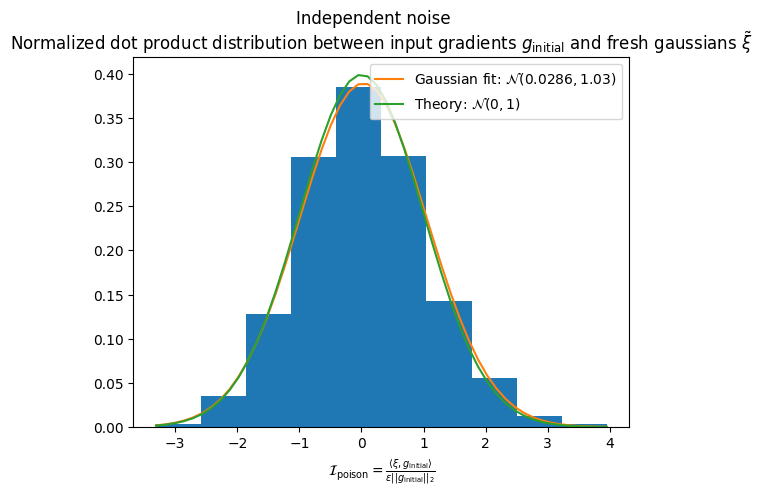

In [25]:
evaluate_unlearning(
    model, loss_func, dummy_pc_dl,
    xi_name=r'fresh gaussians $\tilde{\xi}$', g_name=r'g_{\mathrm{initial}}', method='Independent noise'
)

FIXME : why are values all negative?

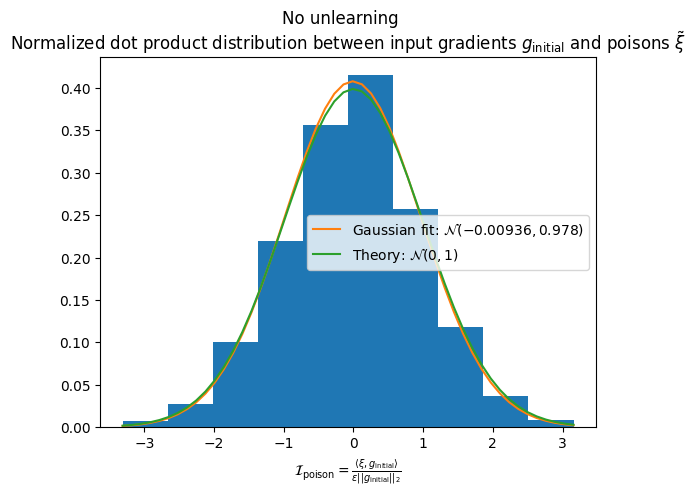

In [26]:
evaluate_unlearning(
    model, loss_func, pc_dl,
    xi_name=r'poisons $\tilde{\xi}$', g_name=r'g_{\mathrm{initial}}', method='No unlearning'
)

For fresh Gaussians, the distribution should be centered around $0$.

Due to data poisoning, the model gradients are influenced by $\xi$ so the distribution is shifted.

### Evaluate unlearning algorithms

We plot the previous distribution again, after running the unlearning algorithm.
If the distribution is still shifted, that means the model did not perfectly unlearn the poisons.

===== Running unlearning gradient descent algorithm =====
Loss: 0.000010  [   64/73500]
Loss: 0.000013  [ 6464/73500]
Loss: 0.000016  [12864/73500]
Loss: 0.000012  [19264/73500]
Loss: 0.000011  [25664/73500]
Loss: 0.000013  [32064/73500]
Loss: 0.000013  [38464/73500]
Loss: 0.000013  [44864/73500]
Loss: 0.000013  [51264/73500]
Loss: 0.000014  [57664/73500]
Loss: 0.000013  [64064/73500]
Loss: 0.000009  [70464/73500]
===== Test  =====
Error: 
 Avg loss: 0.000013 



===== Inspecting model After unlearn_gd =====
Inner state:
 OrderedDict({'linear_relu_stack.0.weight': tensor([[0.7901]], device='cuda:0'), 'linear_relu_stack.0.bias': tensor([0.3929], device='cuda:0')})
(Note : real parameters are tensor([[0.7918]], device='cuda:0'), tensor([0.3894], device='cuda:0'))

===== Test  =====
Error: 
 Avg loss: 0.000054 



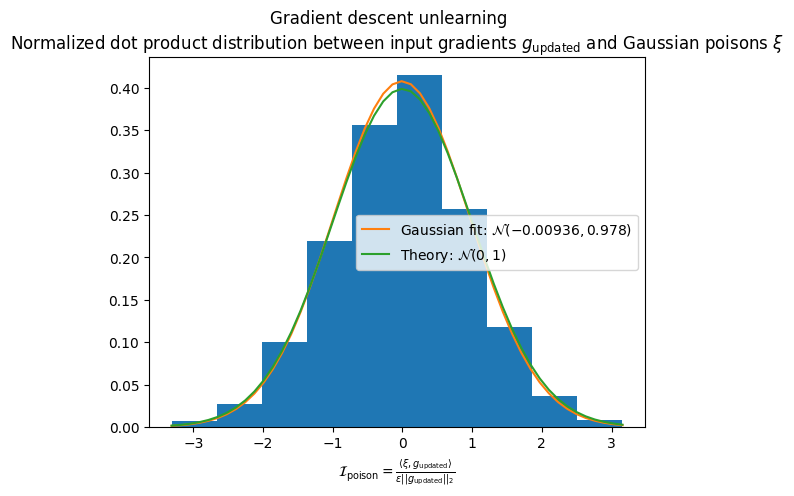

In [27]:
unlearner_model = deepcopy(model)
unlearn_gd(unlearner_model, loss_func, opt)
inspect_model(unlearner_model, 'After unlearn_gd')
test(valid_dl_corrupted, unlearner_model, loss_func)
evaluate_unlearning(
    unlearner_model, loss_func, pc_dl,
    xi_name=r'Gaussian poisons $\xi$',
    g_name=r'g_{\mathrm{updated}}',
    method='Gradient descent unlearning',
)

===== Running unlearning gradient ascent algorithm =====
Loss: -176.962326  [   64/ 1500]
===== Test  =====
Error: 
 Avg loss: 173.124069 



===== Inspecting model After unlearn_ga =====
Inner state:
 OrderedDict({'linear_relu_stack.0.weight': tensor([[-4.1270]], device='cuda:0'), 'linear_relu_stack.0.bias': tensor([-10.2607], device='cuda:0')})
(Note : real parameters are tensor([[0.7918]], device='cuda:0'), tensor([0.3894], device='cuda:0'))

===== Test  =====
Error: 
 Avg loss: 174.260514 



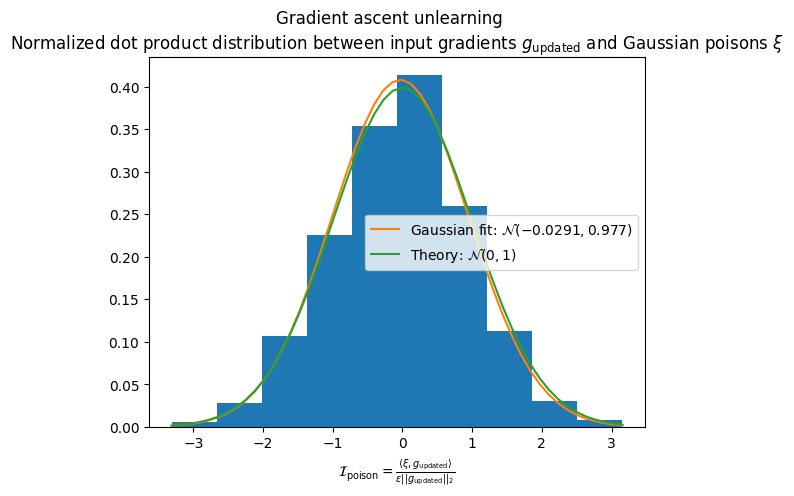

In [28]:
unlearner_model = deepcopy(model)
unlearn_ga(unlearner_model, loss_func, opt)
inspect_model(unlearner_model, 'After unlearn_ga')
test(valid_dl_corrupted, unlearner_model, loss_func)
evaluate_unlearning(
    unlearner_model, loss_func, pc_dl,
    xi_name=r'Gaussian poisons $\xi$',
    g_name=r'g_{\mathrm{updated}}',
    method='Gradient ascent unlearning',
)